In [28]:
import numpy
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Metrics:

In [37]:
def precision(conf_matrix):
  TP = conf_matrix[0][0]
  FP = conf_matrix[0][1]
  return TP/(TP+FP)

def TPR(conf_matrix):
  TP = conf_matrix[0][0]
  FN = conf_matrix[1][0]
  return TP/(TP+FN)

def FPR(conf_matrix):
  FP = conf_matrix[0][1]
  TN = conf_matrix[1][1]
  return FP/(FP+TN)

Get dataset and apply preprocessing

In [133]:
data_file = 'drebin-215-dataset-5560malware-9476-benign.csv'
# SOURCE: https://www.kaggle.com/datasets/shashwatwork/android-malware-dataset-for-machine-learning?select=dataset-features-categories.csv
df = pd.read_csv(data_file)
df = df[~df.eq('?').any(axis=1)]
df = df[~df.eq('unknown').any(axis=1)]

# B=Benign; S=Malware
# change categorical to numerical (1=Malware, 0=Benign)
df['class'].replace(to_replace=['S', 'B'], value=[1,0], inplace=True)

X = df.values[:,:-1].astype(float)
y = df['class'].astype('int').values


<ipython-input-133-90628109ecb9>:2: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


Get Train - Validation - Test splits

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.8*0.25 = 0.2

In [135]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_val = X_val.astype(float)

### Get predictions using a Random Forest Classifier

In [136]:
from sklearn.ensemble import RandomForestClassifier
forest  = RandomForestClassifier(max_depth=10, random_state=0, criterion='entropy')
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=0)

In [137]:
y_pred_test_rf = forest.predict(X_test)

In [138]:
matrix_rf = confusion_matrix(y_test, y_pred_test_rf)
print(f'Random Forest: \nTPR = {"{:.3f}".format(TPR(matrix_rf))}, FPR = {"{:.3f}".format(FPR(matrix_rf))}')

Random Forest: 
TPR = 0.962, FPR = 0.021


In [139]:
from sklearn.metrics import accuracy_score

In [140]:
accuracy_score(y_test, y_pred_test_rf)

0.9680744928500167

### Get predictions using a Support Vector Machine (SVM)

In [141]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [142]:
svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [143]:
y_pred_test_svm = svm_clf.predict(X_test)
matrix_svm = confusion_matrix(y_test, y_pred_test_svm)
print(f'SVM: \nTPR = {"{:.3f}".format(TPR(matrix_svm))}, FPR = {"{:.3f}".format(FPR(matrix_svm))}')

SVM: 
TPR = 0.977, FPR = 0.010


In [144]:
accuracy_score(y_test, y_pred_test_svm)

0.981376787495843

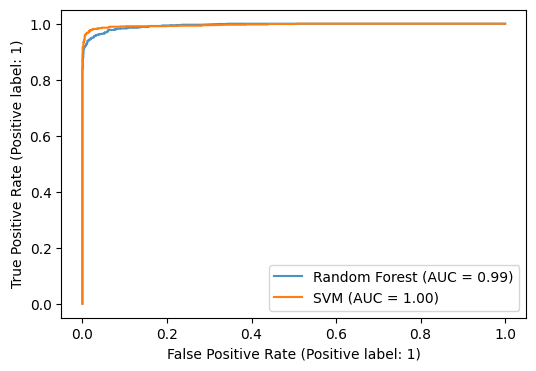

In [64]:
fig, ax = plt.subplots(figsize=(6,4))
sklearn.metrics.RocCurveDisplay.from_estimator(forest, X_test, y_test, ax=ax, alpha=0.8, name='Random Forest')
sklearn.metrics.RocCurveDisplay.from_estimator(svm_clf, X_test, y_test, ax=ax, name='SVM')

### Get predictions using a Neural Network (NN)

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [92]:
class MALWARE_CLASSIFIER(nn.Module):
  def __init__(self, n_features, dropout=0.3):
    super(MALWARE_CLASSIFIER, self).__init__()
    self.L1 = nn.Linear(n_features, 64)
    self.L2 = nn.Linear(64, 32)
    self.dropout = nn.Dropout(p=dropout)
    self.L3 = nn.Linear(32,2)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu(self.L1(x))
    x = self.sigmoid(self.L2(x))
    x = self.dropout(x)
    x = self.L3(x)

    return x
  
  def get_pred(self, X):
    '''
    Get an array of predicted labels by applying softmax to the output layer 
    and getting the class with higher activation.
    '''
    with torch.no_grad():
      outs = model(X)
      probs = F.softmax(outs, dim=1)
      y_hat = torch.argmax(probs, dim=1)
      return y_hat

  def get_acc(self, X, Y):
    with torch.no_grad():
      y_hat = self.get_pred(X)
    
      return (torch.eq(y_hat, Y).sum() / Y.shape[0]).item()

In [118]:
X_train = torch.FloatTensor(X_train)
Y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
Y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)




In [119]:
model = MALWARE_CLASSIFIER(215)
lr = 10**(-3)
momentum = 0.9
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [120]:
max_epochs = 300
batch_size = 64

print_every = 5

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, num_workers=0)

val_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size, num_workers=0)

train_losses = []
val_losses = []

val_acc = []

for epoch in range(max_epochs):
  model.train()
  running_loss = 0.0
  count = 0
  for i, data in enumerate(train_loader, 0):
    optimizer.zero_grad()

    outs = model(data)
    loss = loss_fn(outs, Y_train[i*batch_size:(i+1)*batch_size])
    running_loss += loss.item()
    count += 1
    loss.backward()
    optimizer.step()
  
  with torch.no_grad():
    val_loss = 0
    val_count = 0

    for i, data in enumerate(val_loader, 0):
      outs = model(data)
      loss = loss_fn(outs, Y_val[i*batch_size:(i+1)*batch_size])

      val_loss += loss
      val_count += 1
    
    val_acc.append(model.get_acc(X_val, Y_val))

  train_losses.append(running_loss/count)
  val_losses.append(val_loss/val_count)
  if epoch % print_every == 0:
    print(f'Epoch {epoch}: \n \t Training Loss={train_losses[-1]} Val. Loss={val_losses[-1]}')

  

Epoch 0: 
 	 Training Loss=0.6736770969756106 Val. Loss=0.6500038504600525
Epoch 5: 
 	 Training Loss=0.6294154144347982 Val. Loss=0.6141276955604553
Epoch 10: 
 	 Training Loss=0.48113018866126417 Val. Loss=0.45695605874061584
Epoch 15: 
 	 Training Loss=0.28736914493513444 Val. Loss=0.27963176369667053
Epoch 20: 
 	 Training Loss=0.20924046788866638 Val. Loss=0.190797358751297
Epoch 25: 
 	 Training Loss=0.16878015590263595 Val. Loss=0.1604565531015396
Epoch 30: 
 	 Training Loss=0.15195590379178947 Val. Loss=0.14718033373355865
Epoch 35: 
 	 Training Loss=0.13621668591566966 Val. Loss=0.13360664248466492
Epoch 40: 
 	 Training Loss=0.12497957174976666 Val. Loss=0.12030564993619919
Epoch 45: 
 	 Training Loss=0.1151961550010857 Val. Loss=0.10684667527675629
Epoch 50: 
 	 Training Loss=0.10860036863080154 Val. Loss=0.11160226911306381
Epoch 55: 
 	 Training Loss=0.10318488601251696 Val. Loss=0.10249165445566177
Epoch 60: 
 	 Training Loss=0.10009506879810323 Val. Loss=0.09447282552719

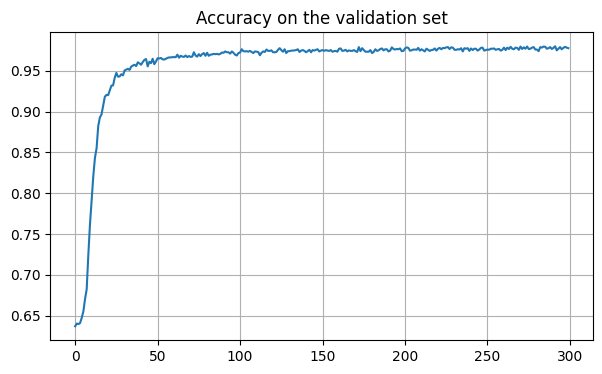

In [121]:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(val_acc)
ax.set_title('Accuracy on the validation set')
ax.grid()
fig.show()

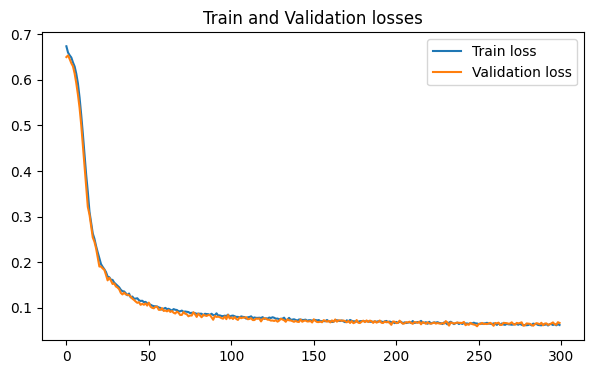

In [122]:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(train_losses, label='Train loss')
ax.plot(val_losses, label='Validation loss')
ax.set_title('Train and Validation losses')
ax.legend()
fig.show()

In [123]:
y_hat = model.get_pred(X_test)
matrix_nn = confusion_matrix(y_hat, y_test)
print(f'Neural Network: \nTPR = {"{:.3f}".format(TPR(matrix_nn))}, FPR = {"{:.3f}".format(FPR(matrix_nn))}')

Neural Network: 
TPR = 0.979, FPR = 0.033


In [125]:
print(f'NN accuracy: {model.get_acc(X_test, y_test)}')

NN accuracy: 0.9737279415130615
